# **ISFS Station Observations vs WRF Gridpoint Evaluation**
#### This notebook performs the following tasks:
> - #### Reads in observational data from 18 ISFS stations deployed during SWEX and model data from the IOP 10 WRF run.
> - #### Grabs 5-minute 10m windspeed and computes 2m dewpoint (using metpy) for each of the 18 ISFS stations and averages them to 10 minute averages to match WRF.
> - #### Interpolates a WRF gridpoint to each of the 18 ISFS stations and grabs 10m windspeed and computes 2m dewpoint (using metpy) for each of those gridpoints.
> - #### Computes the mean absolute error (MAE), mean bias error (MBE), root mean square error (RMSE), and correlation between the WRF gridpoint and the ISFS station for all 18 locations for both 10m windspeed and 2m dewpoint.
> - #### Plots the results as colored dots at each ISFS location on a cartopy map (one map for windspeed and one map for dewpoint).

## **Package Imports**
#### Links to documentation for packages
> - #### [xwrf](https://xwrf.readthedocs.io/en/latest/) | [pathlib](https://docs.python.org/3/library/pathlib.html) | [numpy](https://numpy.org/doc/stable/) | [pandas](https://pandas.pydata.org/docs/) | [xarray](https://docs.xarray.dev/en/stable/) | [matplotlib](https://matplotlib.org/stable/index.html) | [metpy](https://unidata.github.io/MetPy/latest/index.html)
> - #### Documentation for packages linked above should mostly correspond to the most stable versions, which may not be the exact versions used when creating this notebook.
> - #### Comments are also included in the actual code cells. Commented links above certain pieces of code are provided to help show where some lines were copied from. It is possible that there may still be snippets of code here that were simply grabbed off the internet, from places like StackOverflow, without any atribution.

In [1]:
#----------------------------------------
#Entire packages
import xwrf
import pathlib
import numpy as np
import pandas as pd
import xarray as xr

#cartopy imports
import cartopy.crs as ccrs

#matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as mplf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#metpy imports
import metpy.calc as mpcalc
from metpy.units import units

#mapping function notebook
%run ./functions_swex_iop_10.ipynb
#----------------------------------------

ERROR 1: PROJ: proj_create_from_database: Open of /home/sbarc/students/mariandob/mambaforge/envs/swex/share/proj failed


## **Define variables that point to relative paths for relevant data**
### Data Information
> - #### **NCAR Integrated Surface Flux System (ISFS) Stations (format: NetCDF)**
>> - #### **ISFS Variables Used: 10m u and v wind components from Gill Wind Observer (barb; units: m/s converted to knots in plotting phase)**
>> - #### Set of stations deployed by NCAR during the SWEX 2022 field campaign.
>> - #### NetCDF files contain 5-minute resolution observations for individual days.
>> - #### Some documentation for ISFS stations: [Link to SWEX Dataset](https://data.eol.ucar.edu/dataset/600.016) | [List of various ISFS guides](https://www.eol.ucar.edu/content/isfs-guides) | [Sensor list](https://www.eol.ucar.edu/content/isfs-sensor-list) | [Variable naming](https://www.eol.ucar.edu/content/isfs-variable-names)
>> - #### The ISFS station files used for this analysis have been processed so that each file contains the entire timeseries for a select number of variables for individual stations.
>> - #### ISFS variables are averaged over a 5-minute sampling window. The resulting average is (presumably) placed at the midpoint of the 5-minute sampling window.

> - #### **WRF Output Data**
>> - #### Temporal Resolution: 10-minutes
>> - #### Spatial Resolution: d01: 9km | d02: 3km | d03: 1km
>> - #### Lateral and Boundary Conditions: ERA5 Reanalysis
>> - #### See [Jones et al. (2021)](https://www.sciencedirect.com/science/article/pii/S0169809520312424) for more information on parameterization schemes used. Although that WRF downscaling dataset is different from the one used here, the parameterization set up is the same.

In [2]:
#----------------------------------------
#Path to ISFS station data
path_to_isfs_files = sorted(pathlib.Path('./data_swex/observations_ground/entire_campaign_isfs_v1_single_station/').glob('*.nc'))

#Path to WRF data (specifically just the inner most, 1km domain, d03)
path_to_wrf_files  = sorted(pathlib.Path('/home/voyager-sbarc/wrf/wrf460/sundowners/swex2022/iop10/run_1km_545_24_z107_2way/').glob('wrfout_d03*'))

#Display paths to make sure we have data
display(path_to_isfs_files)
print(' ')
display(path_to_wrf_files)
#----------------------------------------

[PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s01.nc'),
 PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s02.nc'),
 PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s03.nc'),
 PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s04.nc'),
 PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s05.nc'),
 PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s06.nc'),
 PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s07.nc'),
 PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s08.nc'),
 PosixPath('data_swex/observations_ground/entire_campaign_isfs_v1_single_station/isfs_swex_qc_5min_s09.nc'),
 PosixPath('data_sw

[PosixPath('/home/voyager-sbarc/wrf/wrf460/sundowners/swex2022/iop10/run_1km_545_24_z107_2way/wrfout_d03_2022-05-11_18:00:00')]

## **Define string prefixes that correspond to ISFS station variables that are in our processed ISFS NetCDF files**
### Notes
> - #### These strings represent prefixes to the ISFS variables names located in the associated NetCDF files. You can add the tower number (1-18; no zero padding) to the end of each prefix to grab the variable for that specific ISFS tower.

In [3]:
#-----------------------------------------------------
#Gill Wind Observer variables
snc_temp_10m_gill_prefix = 'Tc_10m_s'  #Sonic temp. at 10m    | Gill Wind Observer | Units: °C
spd_wind_10m_gill_prefix = 'Spd_10m_s' #speed of 10m wind     | Gill Wind Observer | Units: m/s
dir_wind_10m_gill_prefix = 'Dir_10m_s' #direction of 10m wind | Gill Wind Observer | Units: °
u_wind_10m_gill_prefix   = 'U_10m_s'   #u-comp. of 10m wind   | Gill Wind Observer | Units: m/s
v_wind_10m_gill_prefix   = 'V_10m_s'   #v-comp. of 10m wind   | Gill Wind Observer | Units: m/s
#-----------------------------------------------------
#CSAT3 variables
v_temp_csat_prefix   = 'tc_s'  #virtual air temp. from speed of sound | CSAT3 | Units: °C
spd_wind_csat_prefix = 'spd_s' #speed of wind       | CSAT3 | Units: m/s
dir_wind_csat_prefix = 'dir_s' #direction of wind   | CSAT3 | Units: °
u_wind_csat_prefix   = 'u_s'   #u-component of wind | CSAT3 | Units: m/s
v_wind_csat_prefix   = 'v_s'   #v-component of wind | CSAT3 | Units: m/s
w_wind_csat_prefix   = 'w_s'   #w-component of wind | CSAT3 | Units: m/s
#-----------------------------------------------------
#Paroscientific 6000 variables
baro_pres_paro_prefix = 'P_s' #barometric pressure | Paroscientific 6000 | Units: mb
#-----------------------------------------------------
#CSI IRGA varianles
temp_irga_prefix = 'Tirga_s'    #temperature | CSI IRGA | Units: °C
pres_irga_prefix = 'Pirga_s'    #pressure    | CSI IRGA | Units: mb
vpr_dense_irga_prefix = 'h2o_s' #water vapor density | CSI IRGA | Units: g/m^3
#-----------------------------------------------------
#NCAR hygrothermometer variables
temp_2m_ncar_prefix = 'T_2m_s'  #air temperature at 2m   | NCAR hygrothermometer | Units: °C
relh_2m_ncar_prefix = 'RH_2m_s' #Relative humidity at 2m | NCAR hygrothermometer | Units: %
#-----------------------------------------------------

## **Read in ISFS files, grab variable(s), and perform any needed intermediate computations**
#### Notes
> - #### See inline comments for additional details.

In [11]:
#-----------------------------------------------------
#Define the beginning and end of our time slice for our data
start_time = '2022-05-12 17:00'
end_time   = '2022-05-13 17:00'

#Define a storage locations for specific items
lons_isfs  = []
lats_isfs  = []
total_wind_speed_isfs_list = []
total_dewpoint_isfs_list   = []

#For each ISFS station NetCDF file we have, do the following:
for index, file in enumerate(path_to_isfs_files):
    
    #Open ISFS single station file
    ds_isfs = xr.open_dataset(file)
    
    #Grab station lon/lat information
    lons_isfs.append(ds_isfs.lon)
    lats_isfs.append(ds_isfs.lat)
    
    #Construct variable strings to grab the ISFS variable(s) we want
    u_wind_10m_isfs_str = f'{u_wind_10m_gill_prefix}{index+1}'
    v_wind_10m_isfs_str = f'{v_wind_10m_gill_prefix}{index+1}'
    temp_2m_isfs_str    = f'{temp_2m_ncar_prefix}{index+1}'
    relh_2m_isfs_str    = f'{relh_2m_ncar_prefix}{index+1}'

    #Grab variables based on variable strings
    #Also time slice the data
    u_wind_10m_isfs = ds_isfs[u_wind_10m_isfs_str].sel(time=slice(start_time, end_time))
    v_wind_10m_isfs = ds_isfs[v_wind_10m_isfs_str].sel(time=slice(start_time, end_time))
    temp_2m_isfs    = ds_isfs[temp_2m_isfs_str].sel(time=slice(start_time, end_time))
    relh_2m_isfs    = ds_isfs[relh_2m_isfs_str].sel(time=slice(start_time, end_time))
    
    #Compute total wind speed using metpy function
    total_wind_speed_10m_isfs = mpcalc.wind_speed(u_wind_10m_isfs*units.meter_per_second, v_wind_10m_isfs*units.meter_per_second).metpy.dequantify()
    
    #Compute dewpoint using metpy function
    total_2m_dewpoint_isfs    = mpcalc.dewpoint_from_relative_humidity(temp_2m_isfs*units.degC, relh_2m_isfs*units.percent).metpy.dequantify()
    
    #Add a title and attributes to the new DataArray
    total_wind_speed_10m_isfs.name  = f'10m_wind_speed_s{index+1}'
    total_wind_speed_10m_isfs.attrs = ds_isfs.attrs.copy()
    total_2m_dewpoint_isfs.name     = f'2m_derived_dewpoint_s{index+1}'
    total_2m_dewpoint_isfs.attrs    = ds_isfs.attrs.copy()
    
    #Store the computed DataArray into a list
    total_wind_speed_isfs_list.append(total_wind_speed_10m_isfs)
    total_dewpoint_isfs_list.append(total_2m_dewpoint_isfs)
#-----------------------------------------------------

## **Read in WRF output NetCDF files using xarray and postprocess them using xwrf**
#### Notes
> - #### See inline comments for additional details.

In [12]:
#----------------------------------------
#Read in WRF output file for each domain and use xwrf to postprocess them
wrf_d03_nc = xr.open_dataset(path_to_wrf_files[0], chunks='auto').xwrf.postprocess()

#Destagger WRF output file using xwrf
wrf_d03_nc_destaggered = wrf_d03_nc.xwrf.destagger()

#Display the destaggered WRF xarray Dataset
display(wrf_d03_nc_destaggered)
#----------------------------------------

/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xwrf/grid.py:64: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nx = ds.dims['west_east']
/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xwrf/grid.py:65: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ny = ds.dims['south_north']


<xarray.Dataset> Size: 214GB
Dimensions:                    (Time: 289, y: 234, x: 258, soil_layers: 3,
                                z: 106, seed_dim: 1, snow_layers: 2,
                                snso_layers: 6, x_stag: 259, y_stag: 235,
                                z_stag: 107)
Coordinates: (12/15)
    XLAT                       (y, x) float32 241kB dask.array<chunksize=(234, 258), meta=np.ndarray>
    XLONG                      (y, x) float32 241kB dask.array<chunksize=(234, 258), meta=np.ndarray>
    XTIME                      (Time) timedelta64[ns] 2kB dask.array<chunksize=(289,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 242kB dask.array<chunksize=(234, 259), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 242kB dask.array<chunksize=(234, 259), meta=np.ndarray>
    XLAT_V                     (y_stag, x) float32 243kB dask.array<chunksize=(235, 258), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 428B 1.0 0.9938 ... 0.003495 0.0
  * Time                       (Time) datetime64[ns] 2kB 2022-05-11T18:00:00 ...
  * x                          (x) float64 2kB -1.285e+05 ... 1.285e+05
  * y                          (y) float64 2kB 3.428e+06 3.429e+06 ... 3.661e+06
  * x_stag                     (x_stag) float64 2kB -1.29e+05 ... 1.29e+05
  * y_stag                     (y_stag) float64 2kB 3.427e+06 ... 3.661e+06
Dimensions without coordinates: soil_layers, seed_dim, snow_layers, snso_layers
Data variables: (12/376)
    Times                      (Time) |S19 5kB dask.array<chunksize=(289,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 70MB dask.array<chunksize=(289, 234, 258), meta=np.ndarray>
    ZS                         (Time, soil_layers) float32 3kB dask.array<chunksize=(289, 3), meta=np.ndarray>
    DZS                        (Time, soil_layers) float32 3kB dask.array<chunksize=(289, 3), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 70MB dask.array<chunksize=(289, 234, 258), meta=np.ndarray>
    BATHYMETRY_FLAG            (Time) int32 1kB dask.array<chunksize=(289,), meta=np.ndarray>
    ...                         ...
    air_pressure               (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    geopotential               (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    geopotential_height        (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 7GB dask.array<chunksize=(5, 106, 234, 258), meta=np.ndarray>
    wrf_projection             object 8B +proj=merc +x_0=0 +y_0=0 +a=6370000 ...
Attributes: (12/155)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2022-05-11_18:00:00
    SIMULATION_START_DATE:           2022-05-11_18:00:00
    WEST-EAST_GRID_DIMENSION:        259
    SOUTH-NORTH_GRID_DIMENSION:      235
    BOTTOM-TOP_GRID_DIMENSION:       107
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

## **Grab WRF variable(s) of interest and perform any needed intermediate computations**
### Notes
> - #### See inline comments for additional details.

In [16]:
#-----------------------------------------------------
#Read in WRF variables needed for dewpoint computation
temp_2m_k  = wrf_d03_nc_destaggered["T2"]*units.kelvin   #Temperature at 2m in K
mixr_2m_kg = wrf_d03_nc_destaggered["Q2"]                #Mixing ratio at 2m in kg/kg
psfc_pa    = wrf_d03_nc_destaggered["PSFC"]*units.pascal #Surface pressure in Pa

#Convert units for specific WRF variables using metpy
temp_2m_c  = temp_2m_k.metpy.convert_units(units.degC)  #Temperature from K to °C
psfc_hpa   = psfc_pa.metpy.convert_units(units.hPa)     #Pressure from Pa to hPa

#Use metpy function to compute vapor pressure using surface pressure and mixing ratio at 2m
vapor_pressure_hpa = mpcalc.vapor_pressure(psfc_hpa, mixr_2m_kg)

#Use metpy function to compute dewpoint from vapor pressure
dewp_2m_wrf = mpcalc.dewpoint(vapor_pressure_hpa).metpy.dequantify()

#Grab u and v-components of 10m winds and add units
u_wind_10m_wrf = wrf_d03_nc_destaggered['U10']
v_wind_10m_wrf = wrf_d03_nc_destaggered['V10']

#Compute total wind speed and direction using metpy functions
total_wind_speed_10m_wrf = mpcalc.wind_speed(u_wind_10m_wrf, v_wind_10m_wrf).metpy.dequantify()
#-----------------------------------------------------

## **Interpolate WRF gridpoint to each ISFS station**
### Notes
> - #### See inline comments for additional details.

In [ ]:
#-----------------------------------------------------
# Define a storage location for interpolated WRF DataArrays
total_wind_speed_wrf_interp_list = []
total_dewpoint_wrf_interp_list   = []

# NOTE: If you're using xwrf, make sure the dataset has 'lat' and 'lon' coords.
# If not, you may need to use `.xwrf.postprocess()` to set them.
# Assuming total_wind_speed_10m_wrf is already xwrf-aware and has lat/lon coords

#Assign new coordinates to the xarray DataArray so we can use the "nearest" functionality
total_wind_speed_10m_wrf = total_wind_speed_10m_wrf.assign_coords(x=np.unique(total_wind_speed_10m_wrf.XLONG), 
                                                                  y=np.unique(total_wind_speed_10m_wrf.XLAT))

dewp_2m_wrf = dewp_2m_wrf.assign_coords(x=np.unique(dewp_2m_wrf.XLONG), 
                                        y=np.unique(dewp_2m_wrf.XLAT))

# For every ISFS station location, do the following
for lon_lat_isfs_index, (lon_isfs, lat_isfs) in enumerate(zip(lons_isfs, lats_isfs)):

    # Time index the data first
    total_wind_speed_10m_wrf_time_indexed = total_wind_speed_10m_wrf.sel(Time=slice(start_time, end_time))
    dewp_2m_wrf_time_indexed              = dewp_2m_wrf.sel(Time=slice(start_time, end_time))

    # Interpolate to the exact station lat/lon
    wrf_interp_wind = total_wind_speed_10m_wrf_time_indexed.interp(x=lon_isfs, y=lat_isfs, method='linear').transpose()
    wrf_interp_dewp = dewp_2m_wrf_time_indexed.interp(x=lon_isfs, y=lat_isfs, method='linear').transpose()

    # Add a title and attributes to the new DataArray
    wrf_interp_wind.name = f'10m_wind_speed_wrf_interp_s{lon_lat_isfs_index+1}'
    wrf_interp_dewp.name = f'2m_dewpoint_wrf_interp_s{lon_lat_isfs_index+1}'

    # Append to the proper storage location
    total_wind_speed_wrf_interp_list.append(wrf_interp_wind)
    total_dewpoint_wrf_interp_list.append(wrf_interp_dewp)
#-----------------------------------------------------

## **Compute statistics between ISFS station observations and WRF: 10m Wind speed**
### Notes
> - #### This cell will take a while to run since we load the computed statistic Dask DataArrays into memory here.
> - #### See inline comments for additional details.

In [ ]:
#-----------------------------------------------------
#Define storage locations for statistics
mae_list  = []
mbe_list  = []
rmse_list = []
corr_list = []

#For every ISFS station and nearest WRF gridpoint pair, do the following
for station_index, (station, gridpoint) in enumerate(zip(total_wind_speed_isfs_list, total_wind_speed_wrf_interp_list)):
    
    #Grab the observed values that are closest to the WRF values (since observations have finer time resolution)
    station_time_indexed = station.sel(time=gridpoint.Time, method="nearest").load()
    
    #Load WRF gridpoint into memory before doing any computation
    gridpoint = gridpoint.load()

    #Compute Mean Absolute Error (MAE)
    mae = np.abs(gridpoint - station_time_indexed).mean().load()
    mae.name  = f'mae_s{station_index+1}'
    mae.attrs = station.attrs.copy()
    mae_list.append(mae)
    
    #Compute Mean Bias Error (MBE)
    mbe = (gridpoint - station_time_indexed).mean().load()    
    mbe.name  = f'mbe_s{station_index+1}'
    mbe.attrs = station.attrs.copy()
    mbe_list.append(mbe)

    #Compute Root Mean Square Error (RMSE)
    rmse = np.sqrt(((gridpoint - station_time_indexed) ** 2).mean()).load()
    rmse.name  = f'rmse_s{station_index+1}'
    rmse.attrs = station.attrs.copy()
    rmse_list.append(rmse)

    #Compute Pearson Correlation Coefficient
    corr = xr.corr(gridpoint, station_time_indexed).load()
    corr.name  = f'corr_s{station_index+1}'
    corr.attrs = station.attrs.copy()
    corr_list.append(corr)
#-----------------------------------------------------

## **Compute statistics between ISFS station observations and WRF: 2m Dewpoint**
### Notes
> - #### This cell will take a while to run since we load the computed statistic Dask DataArrays into memory here.
> - #### See inline comments for additional details.

In [19]:
#-----------------------------------------------------
#Define storage locations for statistics
mae_list  = []
mbe_list  = []
rmse_list = []
corr_list = []

#For every ISFS station and nearest WRF gridpoint pair, do the following
for station_index, (station, gridpoint) in enumerate(zip(total_dewpoint_isfs_list, total_dewpoint_wrf_interp_list)):
    
    #Grab the observed values that are closest to the WRF values (since observations have finer time resolution)
    station_time_indexed = station.sel(time=gridpoint.Time, method="nearest").load()
    
    #Load WRF gridpoint into memory before doing any computation
    gridpoint = gridpoint.load()

    #Compute Mean Absolute Error (MAE)
    mae = np.abs(gridpoint - station_time_indexed).mean().load()
    mae.name  = f'mae_s{station_index+1}'
    mae.attrs = station.attrs.copy()
    mae_list.append(mae)
    
    #Compute Mean Bias Error (MBE)
    mbe = (gridpoint - station_time_indexed).mean().load()    
    mbe.name  = f'mbe_s{station_index+1}'
    mbe.attrs = station.attrs.copy()
    mbe_list.append(mbe)

    #Compute Root Mean Square Error (RMSE)
    rmse = np.sqrt(((gridpoint - station_time_indexed) ** 2).mean()).load()
    rmse.name  = f'rmse_s{station_index+1}'
    rmse.attrs = station.attrs.copy()
    rmse_list.append(rmse)

    #Compute Pearson Correlation Coefficient
    corr = xr.corr(gridpoint, station_time_indexed).load()
    corr.name  = f'corr_s{station_index+1}'
    corr.attrs = station.attrs.copy()
    corr_list.append(corr)
#-----------------------------------------------------

## **Plot computed statistics on a map: 10m wind speed**
### Notes
> - #### See inline comments for additional details.

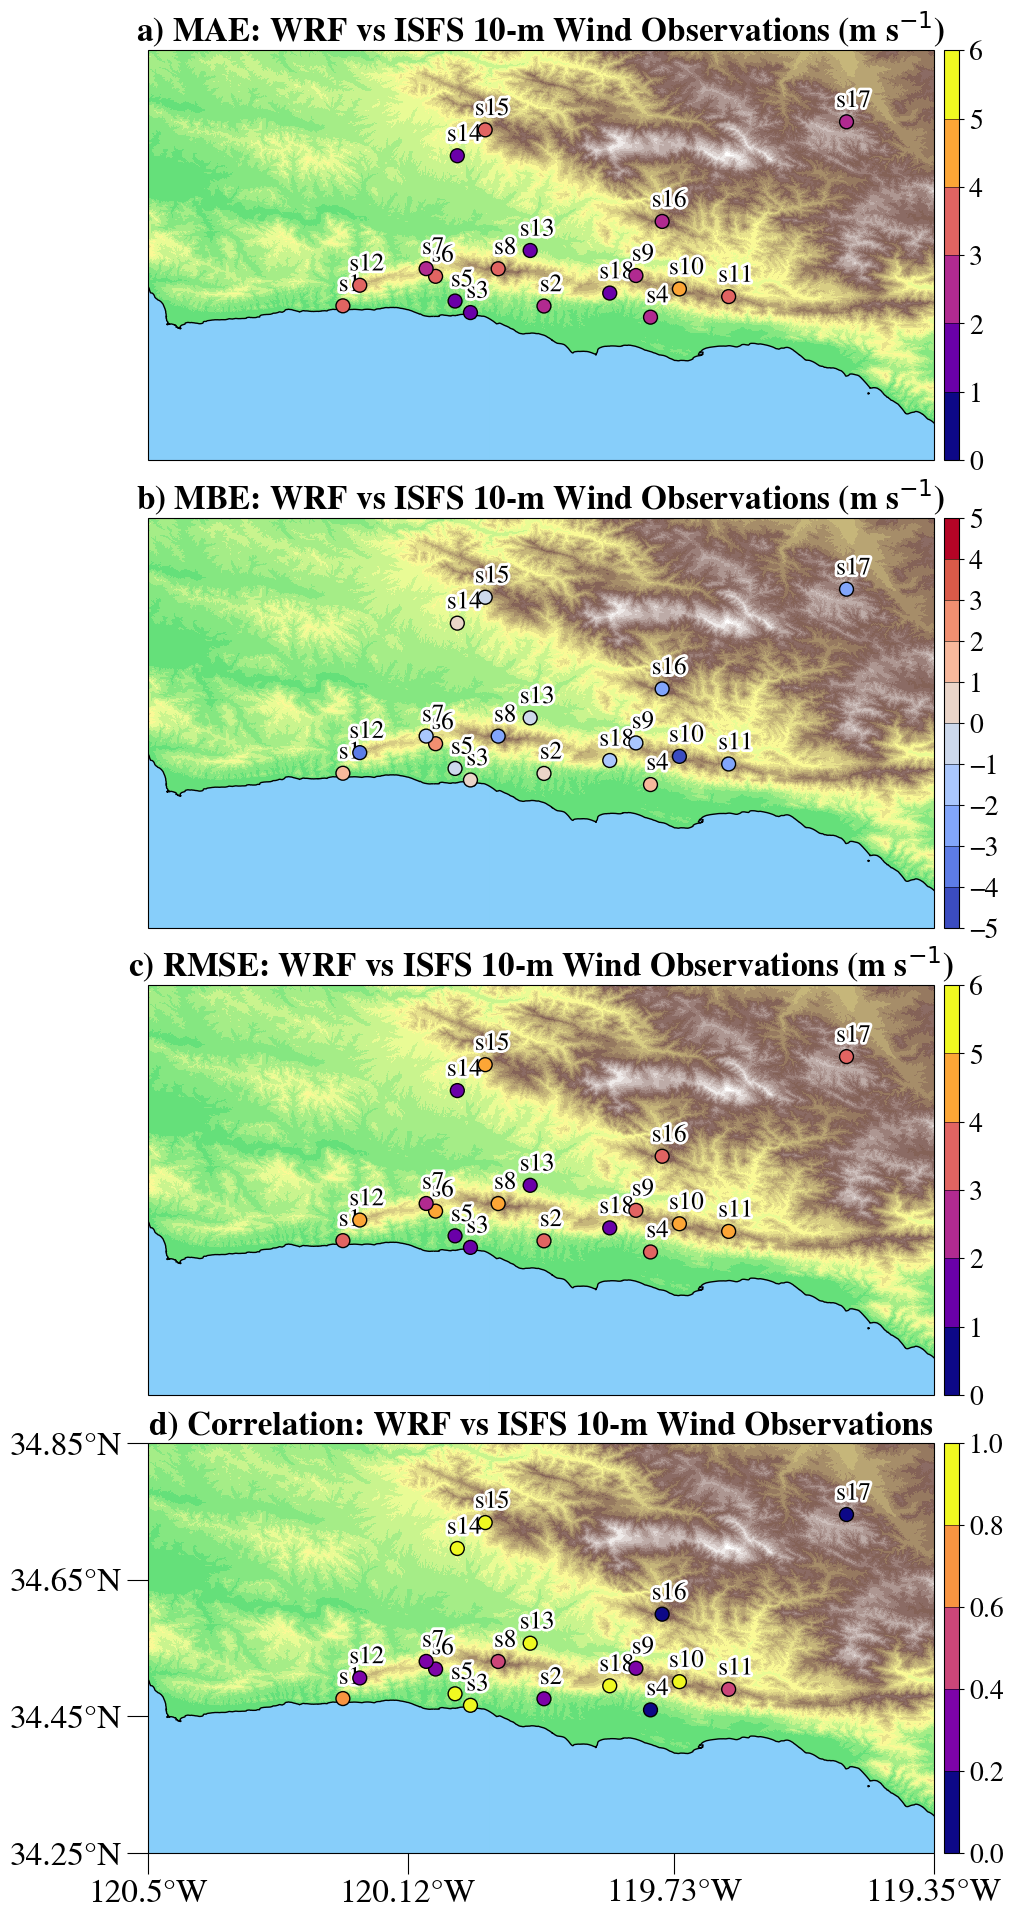

In [8]:
#-----------------------------------------------------
#Define cartopy plot domain in lat/lon coordinates
lon_lat_tick_num = [4, 4]
lon_lat_extent   = [-120.50, -119.35, 34.25, 34.85]
lon_lat_ticks    = [-120.50, -119.35, 34.25, 34.85]

#Define map and data coordinate reference system for our cartopy map
plot_crs = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()

#Define font properties for different items
fontdict_title_labels    = {'fontsize': 24, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_text_annotation = {'fontsize': 18, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_text_color_bar  = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}

#Define a list which will hold the letters that are used to title each subplot
title_list = [r'a) MAE: WRF vs ISFS 10-m Wind Observations (m s$^{-1}$)',
              r'b) MBE: WRF vs ISFS 10-m Wind Observations (m s$^{-1}$)',
              r'c) RMSE: WRF vs ISFS 10-m Wind Observations (m s$^{-1}$)',
              r'd) Correlation: WRF vs ISFS 10-m Wind Observations']

# Metrics dictionary to loop through
metrics = {"MAE": (mae_list, "plasma", [0, 6, 1]),
           "MBE": (mbe_list, "coolwarm", [-5, 5, 1]),
           "RMSE": (rmse_list, "plasma", [0, 6, 1]),
           "Correlation": (corr_list, "plasma", [0, 1, 0.2])}

#Draw cartopy basemap and return fig/axis
fig, axs = cartopy_basemap_subplots(plot_crs=plot_crs, data_crs=data_crs, 
                                    nrows=4, ncols=1, fig_size=(10,20), 
                                    wspace_float=None, hspace_float=None,
                                    lon_lat_extent=lon_lat_extent, 
                                    lon_lat_ticks=lon_lat_ticks, 
                                    lon_lat_tick_num=lon_lat_tick_num, 
                                    lon_lat_ticks_on=True, 
                                    xtick_ytick_set_list=[False, False, False, True],
                                    high_res_coastline=True, 
                                    high_res_wrf_topo_sb_bool=True, 
                                    low_res_wrf_topo_sb_bool=False, 
                                    low_res_wrf_topo_ca_bool=False, 
                                    wrf_topo_colorbar_each_plot_bool=False, 
                                    wrf_topo_colorbar_entire_figure_bool=False,
                                    scale_bar_bool=False, scale_bar_position=None, 
                                    inset_ca_bool=False, inset_bbox_position=None, 
                                    ocean_color='lightskyblue')
#-----------------------------------------------------
#For every axis and specific statistic, do the following:
for index, (ax, (title, (values, cmap, levels))) in enumerate(zip(axs.flatten(), metrics.items())):
    
    #Add title
    ax.set_title(title_list[index], **fontdict_title_labels)
    
    #Add in label text
    for label_index, (lon, lat) in enumerate(zip(lons_isfs, lats_isfs)):
        
        label_text = ax.annotate(f's{label_index+1}', xy=(lon,lat), xytext=((5,15)), 
                                 color='black', textcoords='offset points', 
                                 horizontalalignment='center', verticalalignment='center', **fontdict_text_annotation)
        #Add text effect to label
        #https://matplotlib.org/3.2.1/tutorials/advanced/patheffects_guide.html
        label_text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'), path_effects.Normal()])
    
    #Define levels for the colormap
    colormap_min    = levels[0]
    colormap_max    = levels[1]
    colormap_step   = levels[2]
    colormap_levels = np.arange(colormap_min, colormap_max+colormap_step, colormap_step)

    #Define cmap for contourf and colorbar and set out of bound values
    scatter_cmap = plt.get_cmap(cmap).copy()

    #Set the norm for contourf
    colormap_norm = mcolors.BoundaryNorm(colormap_levels, ncolors=scatter_cmap.N, clip=False)
    
    #Plot ISFS station locations with specific statistic values for each station location
    scatter = ax.scatter(lons_isfs, lats_isfs, c=values, cmap=scatter_cmap, norm=colormap_norm, edgecolor='black', s=100, zorder=5)

    #Create colorbar for values
    #Second Answer: https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
    divider = make_axes_locatable(ax)
    cax     = divider.append_axes("right", size="2%", pad=0.1, axes_class=plt.Axes)
    cbar    = plt.colorbar(scatter, cax=cax, orientation='vertical', spacing='uniform', ticks=list(colormap_levels[::1]), drawedges=True)
    
    #Set font for colorbar tick lables
    #https://stackoverflow.com/questions/7257372/set-font-properties-to-tick-labels-with-matplot-lib/7280803
    ticks_font = mplf.FontProperties(family='Nimbus Roman', style='normal', size=20, weight='normal', stretch='normal')
    for label in cbar.ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
#-----------------------------------------------------
#Save figure
plt.savefig(f'./figures/figure_09_wrf_vs_obs_interp.png', bbox_inches='tight', dpi=500)
#-----------------------------------------------------

## **Plot computed statistics on a map: 2m dewpoint**
### Notes
> - #### See inline comments for additional details.

In [ ]:
#-----------------------------------------------------
#Define cartopy plot domain in lat/lon coordinates
lon_lat_tick_num = [4, 4]
lon_lat_extent   = [-120.50, -119.35, 34.25, 34.85]
lon_lat_ticks    = [-120.50, -119.35, 34.25, 34.85]

#Define map and data coordinate reference system for our cartopy map
plot_crs = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()

#Define font properties for different items
fontdict_title_labels    = {'fontsize': 24, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_text_annotation = {'fontsize': 18, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_text_color_bar  = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}

#Define a list which will hold the letters that are used to title each subplot
title_list = [r'a) MAE: WRF vs ISFS 2-m Dewpoint Observations (°C)',
              r'b) MBE: WRF vs ISFS 2-m Dewpoint Observations (°C)',
              r'c) RMSE: WRF vs ISFS 2-m Dewpoint Observations (°C)',
              r'd) Correlation: WRF vs ISFS 2-m Dewpoint Observations']

# Metrics dictionary to loop through
metrics = {"MAE": (mae_list, "plasma", [0, 6, 1]),
           "MBE": (mbe_list, "coolwarm", [-6, 6, 1]),
           "RMSE": (rmse_list, "plasma", [0, 7, 1]),
           "Correlation": (corr_list, "plasma", [0, 1, 0.2])}

#Draw cartopy basemap and return fig/axis
fig, axs = cartopy_basemap_subplots(plot_crs=plot_crs, data_crs=data_crs, 
                                    nrows=4, ncols=1, fig_size=(10,20), 
                                    wspace_float=None, hspace_float=None,
                                    lon_lat_extent=lon_lat_extent, 
                                    lon_lat_ticks=lon_lat_ticks, 
                                    lon_lat_tick_num=lon_lat_tick_num, 
                                    lon_lat_ticks_on=True, 
                                    xtick_ytick_set_list=[False, False, False, True],
                                    high_res_coastline=True, 
                                    high_res_wrf_topo_sb_bool=True, 
                                    low_res_wrf_topo_sb_bool=False, 
                                    low_res_wrf_topo_ca_bool=False, 
                                    wrf_topo_colorbar_each_plot_bool=False, 
                                    wrf_topo_colorbar_entire_figure_bool=False,
                                    scale_bar_bool=False, scale_bar_position=None, 
                                    inset_ca_bool=False, inset_bbox_position=None, 
                                    ocean_color='lightskyblue')
#-----------------------------------------------------
#For every axis and specific statistic, do the following:
for index, (ax, (title, (values, cmap, levels))) in enumerate(zip(axs.flatten(), metrics.items())):
    
    #Add title
    ax.set_title(title_list[index], **fontdict_title_labels)
    
    #Add in label text
    for label_index, (lon, lat) in enumerate(zip(lons_isfs, lats_isfs)):
        
        label_text = ax.annotate(f's{label_index+1}', xy=(lon,lat), xytext=((5,15)), 
                                 color='black', textcoords='offset points', 
                                 horizontalalignment='center', verticalalignment='center', **fontdict_text_annotation)
        #Add text effect to label
        #https://matplotlib.org/3.2.1/tutorials/advanced/patheffects_guide.html
        label_text.set_path_effects([path_effects.Stroke(linewidth=4, foreground='white'), path_effects.Normal()])
    
    #Define levels for the colormap
    colormap_min    = levels[0]
    colormap_max    = levels[1]
    colormap_step   = levels[2]
    colormap_levels = np.arange(colormap_min, colormap_max+colormap_step, colormap_step)

    #Define cmap for contourf and colorbar and set out of bound values
    scatter_cmap = plt.get_cmap(cmap).copy()

    #Set the norm for contourf
    colormap_norm = mcolors.BoundaryNorm(colormap_levels, ncolors=scatter_cmap.N, clip=False)
    
    #Plot ISFS station locations with specific statistic values for each station location
    scatter = ax.scatter(lons_isfs, lats_isfs, c=values, cmap=scatter_cmap, norm=colormap_norm, edgecolor='black', s=100, zorder=5)

    #Create colorbar for values
    #Second Answer: https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
    divider = make_axes_locatable(ax)
    cax     = divider.append_axes("right", size="2%", pad=0.1, axes_class=plt.Axes)
    cbar    = plt.colorbar(scatter, cax=cax, orientation='vertical', spacing='uniform', ticks=list(colormap_levels[::1]), drawedges=True)
    
    #Set font for colorbar tick lables
    #https://stackoverflow.com/questions/7257372/set-font-properties-to-tick-labels-with-matplot-lib/7280803
    ticks_font = mplf.FontProperties(family='Nimbus Roman', style='normal', size=20, weight='normal', stretch='normal')
    for label in cbar.ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
#-----------------------------------------------------
#Save figure
plt.savefig(f'./figures/figure_s04_wrf_vs_obs_interp_2m_dewp.png', bbox_inches='tight', dpi=500)
#-----------------------------------------------------